In [1]:
%matplotlib widget
import contextily as cx
from matplotlib.pyplot import figure, draw, pause
from xyzservices import TileProvider
from matplotlib.axes import Axes
import xarray as xa
import geopandas
import rasterio
import matplotlib.pyplot as plt

In [2]:
result_dir = "/Users/tpmaxwel/Development/Data/raster/tiles"
SpectralDataset = f"{result_dir}/DESIS-HSI-L1C-DT0468853252_003-20200628T153803-V0210-SPECTRAL_IMAGE.nc"
dataset: xa.Dataset = xa.open_dataset( SpectralDataset, decode_coords='all' )
raster: xa.DataArray = dataset.data_vars['z']
classes = dict( water='blue', vegetation='green', urban='grey' )
band = 100

In [3]:
class DynamicBasemap:

    def __init__(self, ax: Axes, source: TileProvider, **kwargs ):
        self.ax: Axes = ax
        self.source: TileProvider = source
        self.ax.callbacks.connect( 'xlim_changed', self.on_lims_change )
        self.crs: str = kwargs.get('crs',None)
        self.basemap = self.add_basemap( **kwargs )

    def on_lims_change( self, *args, **kwargs ):
        print( f"lims-changed: {args} {kwargs}")
    #    new_img =
    #    basemap_image.set_data( new_img )
    #    draw(), pause(1e-3)

    def reproject_bounds(self, left, right, bottom, top, s_crs, t_crs):
        from rasterio.warp import transform_bounds
        n_l, n_b, n_r, n_t = transform_bounds(s_crs, t_crs, left, bottom, right, top)
        return n_l, n_r, n_b, n_t

    def add_basemap( self, **kwargs ):
        from contextily.tile import bounds2img, warp_tiles
#        reset_extent = kwargs.get( 'reset',False )

        xmin, xmax, ymin, ymax = ax.axis()
        if self.crs is not None:
            xmin, xmax, ymin, ymax = self.reproject_bounds(  xmin, xmax, ymin, ymax, self.crs, {"init": "epsg:3857"} )

        image, extent = bounds2img( xmin, xmax, ymin, ymax, source=self.source, ll=False )

        if self.crs is not None:
            image, extent = warp_tiles( image, extent, t_crs=self.crs )

        if image.shape[2] == 1: image = image[:, :, 0]
        img = ax.imshow( image, extent=extent, zorder=9 )

        # if reset_extent:
        #     ax.axis((xmin, xmax, ymin, ymax))
        # else:
        #     max_bounds = ( min(xmin, extent[0]), max(xmax, extent[1]), min(ymin, extent[2]), max(ymax, extent[3]) )
        #     ax.axis(max_bounds)
        return img

<class 'matplotlib.axes._subplots.AxesSubplot'>
lims-changed: (<AxesSubplot:title={'center':'band = 101, spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>,) {}


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
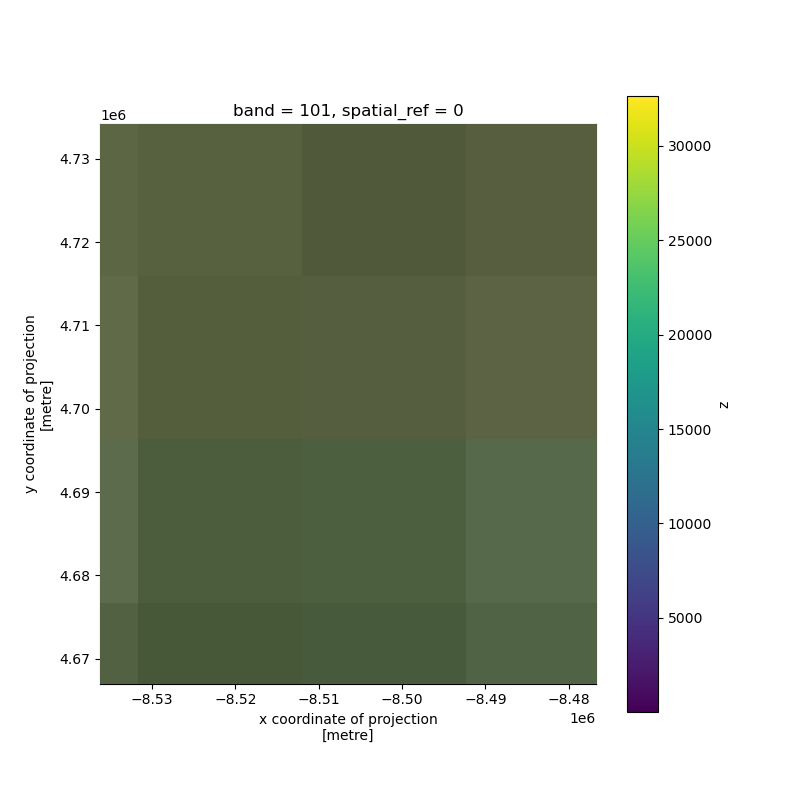

In [4]:
fig, ax = plt.subplots(1,1, figsize=(8.0,8.0) )
print( type(ax) )
raster[band].plot( ax=ax )
# basemap = DynamicBasemap( ax, source=cx.providers.Esri.WorldImagery )
plt.show()